In [2]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.plotting import register_matplotlib_converters
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

register_matplotlib_converters()
ee.Initialize()

In [3]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied, currently works for 2000 - 2018
3) Scale (optional): Resolution at which to perform analysis (if not specified, calculated automatically in EE)
4) Satellites / datasets: Queried from Earth Engine, defined in data[sat1...] 
'''

##### AREA #####

# CV
cv = gp.read_file("../shape/cv.shp")
cv_km3 = round(cv.area[0] * 10, 2)* 1000

# HUC 4s draining to the CV 
ssjt = gp.read_file("../shape/cv_hu6.shp")
ssjt2 = ssjt.geometry.simplify(0.1) # This reduces the # of geometries submitted to EE and makes things run mucho faster 
lls = ssjt2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)

# Get the area of the ssjt wshed 
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")
sa_km3 = unary_union([s1.geometry[0], s2.geometry[0], s3.geometry[0]]).area * 10000

# Grace area
ga = gp.read_file("../shape/argus_grace.shp")

##### TIME RANGE #####
years = [x for x in range(2001, 2018)]

months = range(1,13)


In [4]:
# Read and format data 

In [133]:
# CV and SSJT RS data

cvdf = pd.read_csv("../data/all_data_cv.csv")
df = pd.read_csv("../data/all_data_ssjt.csv")

# Initialize the datetime columns
cvdf['dt'] = pd.to_datetime(df[df.columns[0]])
cvdf = cvdf.set_index(pd.to_datetime(cvdf[cvdf.columns[0]]))
cvdf.drop(cvdf.columns[0],axis = 1, inplace = True)

df['dt'] = pd.to_datetime(df[df.columns[0]])
df = df.set_index(pd.to_datetime(df[df.columns[0]]))
df.drop(cvdf.columns[0],axis = 1, inplace = True)

# Chop off the first n rows of nodata
cvdf = cvdf.iloc[327:]
# df = df.iloc[327:]

In [134]:
# Grace data

grace = pd.read_csv("../data/grace_argus.csv")

# Initialize the datetime columns
grace['dt'] = pd.to_datetime(grace[grace.columns[0]])
grace = grace.set_index(pd.to_datetime(grace[grace.columns[0]]))
grace.drop(["dt"],axis = 1, inplace = True)

# Subtract reservoir storage and soil moisture from grace 
grace['adj'] = grace.grace_mean[1:] - df.soil_moisture.diff()[1:] - df.res_s.diff()[1:] - df.swe.diff()[1:]
grace['adj'][0] = 0
# grace['adj'] = grace.grace_mean[1:] - cvdf.soil_moisture.diff()[1:] - cvdf.res_s.diff()[1:]

/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [135]:
# Wells data (processed by zihan using Faunt 2009 SY values )

wells = pd.read_csv("../data/wells_ds_faunt_sy.csv")
wells.month = wells.month.astype(str)
wells.year = wells.year.astype(str)
wells.month = wells.month.str.zfill(2)

wells['Date'] = pd.to_datetime(wells.year + wells.month , format="%Y%m") + MonthEnd(1)
wells.index = wells.Date
wells.drop(['Date'], axis =1, inplace = True)

wells['ds_km3'] = wells[wells.columns[-1]] * 50000 * 1e-5

In [136]:
# CV et scaling factors

etdf = pd.read_csv("../data/et_kc.csv")
etdf = etdf.set_index(pd.to_datetime(etdf[etdf.columns[0]]))
etdf.drop(etdf.columns[0],axis = 1, inplace = True)

# Select the first year of scaling factors and apply this to the first 7 years of data
repeat_arr = etdf.et_multiplier[0:12]
t = pd.merge(cvdf, etdf,how = "outer", left_index = True, right_index = True)
t.drop(t.tail(12).index,inplace=True)

# Make 7 concats of the yearly dataframe, fill the nans in the cvdf with that
temp = pd.DataFrame(repeat_arr)
temp = pd.concat([temp]*7, ignore_index=True)
t.et_multiplier[t.et_multiplier.isna()] = temp[temp.columns[0]].values

/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


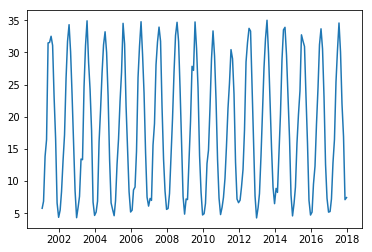

In [147]:
plt.plot(df.gmet_eto)

In [143]:
# Water balances

# Make a modified ET balamce as modis + gmet scaled by area
df['et_acc'] = df['modis'] - cvdf['modis'] + cvdf['et_mean']

# Calc the CV Wshed balance
df['q_out2'] = df['q_out2'].fillna(value = 0)
df['ds'] = df.p_mean - df.et_acc  - df.q_out1 - df.q_out2 - df.soil_moisture.diff() - df.res_s.diff() - df.swe.diff()

# Calc the CV balance
cvdf['ds'] = cvdf.p_mean - cvdf.et_mean + cvdf.runoff - cvdf.q_out + cvdf.q_in - cvdf.soil_moisture.diff() -cvdf.res_s.diff()

In [144]:
# Plot 

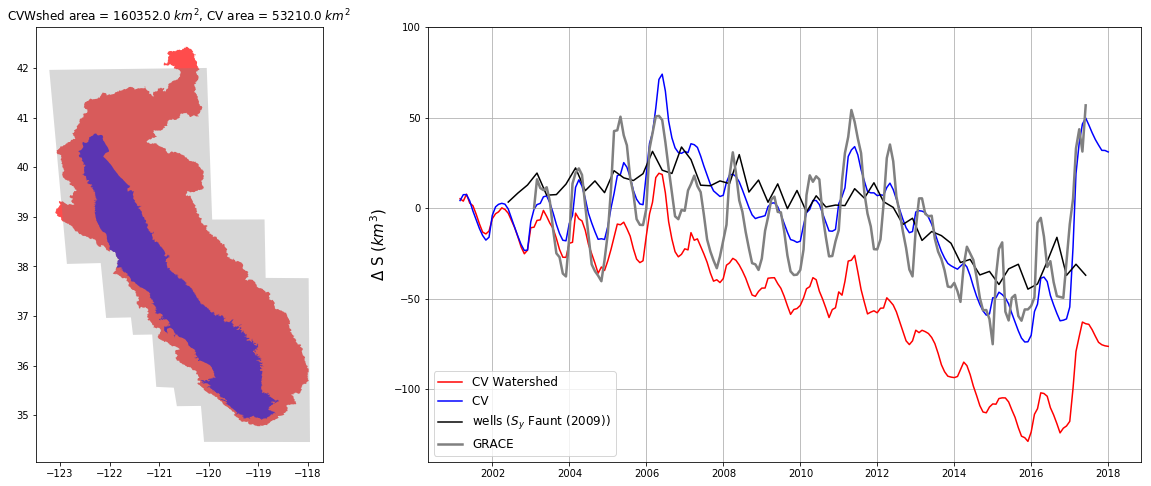

In [145]:
# import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


plt.figure(figsize=(20, 8))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
ga.plot(label = "grace footprint", ax=axes_1, color = "gray", alpha = 0.3, legend = True)
axes_1.set_title("CVWshed area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 0), round(cv_km3, 0)))

axes_4 = plt.subplot(G[0:2, 1:])

axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "CV Watershed")
axes_4.plot(cvdf.index, np.cumsum(cvdf.ds), color="blue", label = "CV ")
# axes_4.plot(cvdf.index[1:], np.cumsum(cvdf.s.diff()[1:]), color="green", label = "C2VSIM")
axes_4.plot(wells.index, wells.ds_km3, color="black", label = "wells ($S_y$ Faunt (2009))")
axes_4.plot(grace.index, grace.adj, color="gray", label = "GRACE", linewidth = 2.5)
# axes_4.plot(grace.index, grace.adj, color="green", label = "grace")

axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend(prop={'size': 12}, loc = "lower left")
axes_4.set_ylim(-140, 100)
# axes_4.set_xlim("01-01-2001", "01-01-2018")

# axes_4.set_xticks(np.arange(min(df.index), max(df.index)+1,1.0))
datemin = np.datetime64(cvdf.index[0], 'Y')
datemax = np.datetime64(df.index[-1], 'Y') + np.timedelta64(1, 'Y')

# axes_4.set_xticks([datemin, datemax,1])

plt.grid(True)
G.update(wspace=0.3, hspace=0.3) # set the spacing between axes. 
# plt.tight_layout()
plt.show()

In [11]:
# Read xiao hydrology model

x = pd.read_csv("../data/xiao_ds.txt", header = None, sep = " ")
x['dt'] = pd.to_datetime(x[x.columns[0]])
x = x.set_index(pd.to_datetime(x[x.columns[0]]))
x.drop([x.columns[0],x.columns[1], 'dt'],axis = 1, inplace = True)

In [12]:
# read xiao grace data 

gr = pd.read_csv("../data/grace_xiao.csv", header = None, sep = ",")
gr['dt'] = pd.to_datetime(gr[gr.columns[0]])
gr = gr.set_index(pd.to_datetime(gr[gr.columns[0]]))
gr.drop([gr.columns[0], 'dt'],axis = 1, inplace = True)

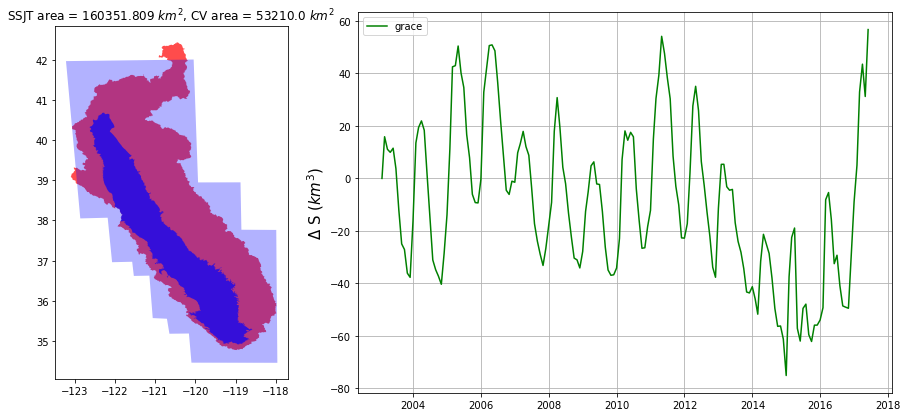

In [13]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
ga.plot(label = "grace footprint", ax=axes_1, color = "blue", alpha = 0.3, legend = True)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_4 = plt.subplot(G[0:2, 1:])

# axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS - CV Watershed")
# axes_4.plot(cvdf.index, np.cumsum(cvdf.ds), color="purple", label = "RS - CV ")
# axes_4.plot(cvdf.index[1:], np.cumsum(cvdf.s.diff()[1:]), color="blue", label = "C2VSIM")
# axes_4.plot(wells.index, wells.ds_km3, color="black", label = "wells1")
# axes_4.plot(wells.index, wells.ds_km3_2, color="black", label = "wells")
axes_4.plot(grace.index, grace.adj, color="green", label = "grace")
# axes_4.plot(grace.index, grace.adj, color="green", label = "grace")
# axes_4.plot(gr.index, gr[gr.columns[0]], color="orange", label = "grace (Xiao et al., 2017)")
# axes_4.plot(x.index, x[x.columns[0]], color="gray", label = "Xiao et al., 2017")


axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.grid(True)
G.update(wspace=0.3, hspace=0.1) # set the spacing between axes. 
# plt.tight_layout()
plt.show()

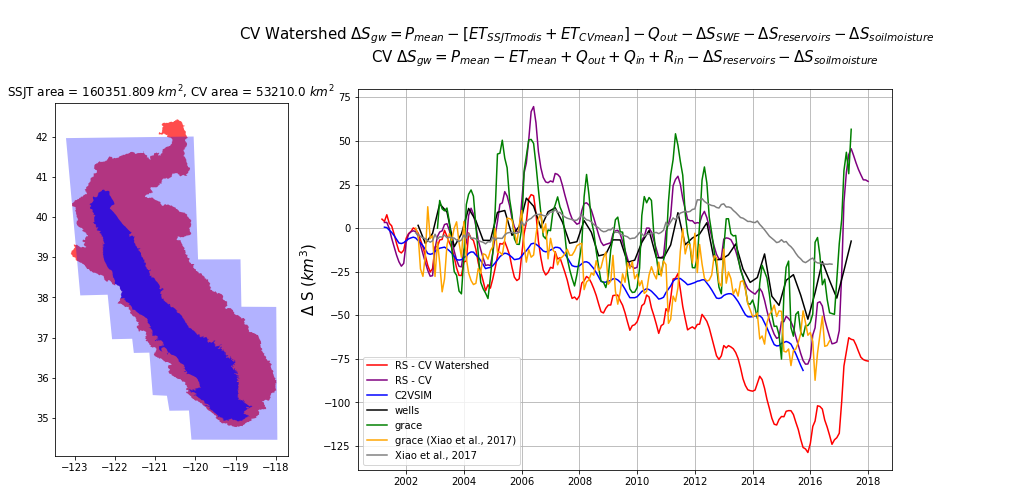

In [14]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
ga.plot(label = "grace footprint", ax=axes_1, color = "blue", alpha = 0.3, legend = True)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_4 = plt.subplot(G[0:2, 1:])
axes_4.set_title("""
CV Watershed $\Delta S_{gw} = P_{mean} - [ET_{SSJT modis} + ET_{CV mean}] - Q_{out} - \Delta S_{SWE} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$                 
CV $\Delta S_{gw} = P_{mean} - ET_{mean} + Q_{out} + Q_{in} + R_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture} $
""", size = 15)

axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS - CV Watershed")
axes_4.plot(cvdf.index, np.cumsum(cvdf.ds), color="purple", label = "RS - CV ")
axes_4.plot(cvdf.index[1:], np.cumsum(cvdf.s.diff()[1:]), color="blue", label = "C2VSIM")
# axes_4.plot(wells.index, wells.ds_km3, color="black", label = "wells1")
axes_4.plot(wells.index, wells.ds_km3_2, color="black", label = "wells")
axes_4.plot(grace.index, grace.adj, color="green", label = "grace")
# axes_4.plot(grace.index, grace.adj, color="green", label = "grace")
axes_4.plot(gr.index, gr[gr.columns[0]], color="orange", label = "grace (Xiao et al., 2017)")
axes_4.plot(x.index, x[x.columns[0]], color="gray", label = "Xiao et al., 2017")


axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.grid(True)
G.update(wspace=0.3, hspace=0.1) # set the spacing between axes. 
# plt.tight_layout()
plt.show()

In [15]:
# Do triple collocation on grace, wells, rs model

def calc_tc_error(x,y,z):
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    return ((src - np.mean(src)) /
            np.std(src)) * np.std(ref) + np.mean(ref)

In [24]:
x = np.cumsum(cvdf.ds)
y = wells.ds_km3_2
z = grace.adj


In [25]:
y_scaled = scale_to_ref(y, x)
z_scaled = scale_to_ref(z, x)

In [26]:
e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)
print (e_x,e_y,e_z)

8.121998488644007 14.480661867845589 16.05752357526622


In [1]:
t1 = pd.merge(cvdf, wells, left_index=True, right_index=True, how = "outer")
t2 = pd.merge(t1, grace, left_index=True, right_index=True, how = "outer")

NameError: name 'pd' is not defined

In [161]:
t2['cs'] = np.cumsum(t2.ds)
t2['ds_mean'] = np.nanmean(t2[['adj', 'ds_km3', "cs"]], axis = 1)

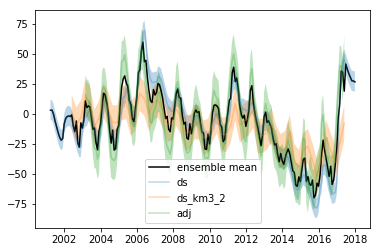

In [171]:
plt.plot(t2.ds_mean, color = "black", label = 'ensemble mean')
plt.plot(cvdf.index, x, alpha = 0.3)
plt.fill_between(cvdf.index, x+e_x, x-e_x, alpha = 0.3)
plt.plot(wells.index, y, alpha = 0.3)
plt.fill_between(wells.index, y+e_y, y-e_y, alpha = 0.3)
plt.plot(grace.index, z, alpha = 0.3)
plt.fill_between(grace.index, z+e_z, z-e_z, alpha = 0.3)
plt.legend()